In [1]:
#Kittipong Wangnok
#School of Physics, Institute of Science, Suranaree University of Technology
#Import module
import sys
import os
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from matplotlib import pyplot as plt

from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif',size=14)

In [2]:
ls

2022_July_week2_OC_New_ephemeris.pdf
Beuermann2011_generated_model.pdf
Kaggle.ipynb
Kaggle_linear.ipynb
OC_LTT_dpleo_brute.ipynb
decaying_sine_wave_brute.ipynb
generate_model_brute.ipynb
interporate_lnLTT_fit_Beuermann.out
oc_dpleo_Beuermann_Schwope_Kittipong.inp
oc_linear_dpleo_Beuermann_Schwope_Kittipong_ephemeris_determination.txt


In [3]:
#Read data ---#1
Input = "oc_dpleo_Beuermann_Schwope_Kittipong.inp"
Data   = np.genfromtxt(Input)

Epoch = Data[:,0]
T_obs = Data[:,1]
T_obs_err = Data[:,2]

#print(len(Epoch))

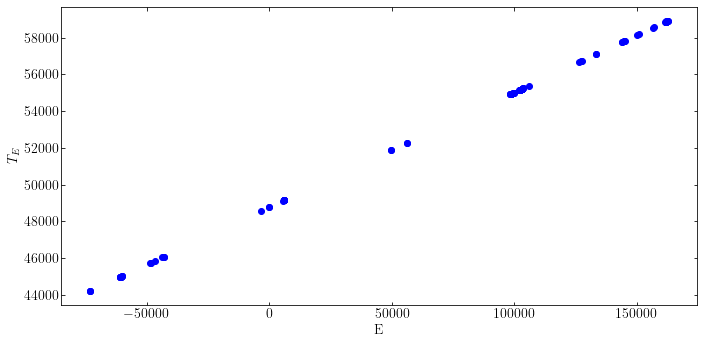

In [4]:
fig, (ax0) = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(10, 5), tight_layout=True)
#plt.xlim(-0.04,0.04)
#plt.xlabel('Orbital phase')

ax0.tick_params(direction='in', which='both', bottom='on',top='on', right = 'on')
#ax1.tick_params(direction='in', which='both', bottom='on',top='on', right = 'on')

ax0.errorbar(Epoch, T_obs, yerr= T_obs_err, fmt='o', color='blue',
             ecolor='lightgray', elinewidth=1, capsize=0)


#ax0.legend(loc="best")
ax0.set_xlabel('E')
ax0.set_ylabel('$T_{E}$')

#ax0.set_ylim(-30, 40)

fig.align_ylabels()
#output_filename = os.path.splitext(__file__)[0] + '.png'
#plt.savefig(output_filename, dpi=1000)
#plt.savefig("spot_longitude_Beuermann_Kittipong.png")
plt.show()

In [5]:
x = Epoch
y = T_obs
dy = T_obs_err

len_x = len(x)
#print(len_x)

In [6]:
import copy

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np

from lmfit import Minimizer, Parameters, fit_report

In [7]:
def linear_fit(params, x, y):
    m = params['m']
    c = params['c']
    model = m*x + c
    return model - y

In [8]:
# create a set of Parameters
params = Parameters()
#params.add('m', value=0.062362846562657996, min=0)
#params.add('c', value=48773.21447208912, min=0)

params.add('m', value=0.06236284988039249)
params.add('c', value=48773.21418374931)

params['m'].set(brute_step=0.0025)
params['c'].set(brute_step=500)

In [9]:
params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
c  4.877e+04     -inf      inf     None     True     None      500
m   0.06236     -inf      inf     None     True     None   0.0025


In [10]:
fitter = Minimizer(linear_fit, params, fcn_args=(x, y))
result_brute = fitter.minimize(method='brute', Ns=250, keep=250)

In [11]:
print(fit_report(result_brute))

[[Fit Statistics]]
    # fitting method   = brute
    # function evals   = 62500
    # data points      = 113
    # variables        = 2
    chi-square         = 4.2666e-05
    reduced chi-square = 3.8438e-07
    Akaike info crit   = -1667.21328
    Bayesian info crit = -1661.75850
##  Warning: uncertainties could not be estimated:
    m:  at initial value
    c:  at initial value
[[Variables]]
    m:  0.06236285 (init = 0.06236285)
    c:  48773.2142 (init = 48773.21)


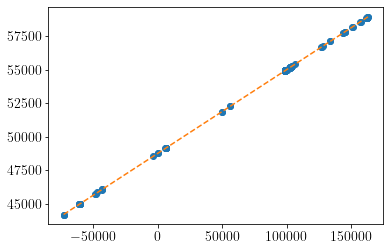

In [12]:
plt.plot(x, y, 'o')
plt.plot(x, y + linear_fit(result_brute.params, x, y), '--')
plt.show()

In [13]:
result_brute.show_candidates(1)


Candidate #1, chisqr = 0.000
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
c  4.877e+04     -inf      inf     None     True     None      500
m   0.06236     -inf      inf     None     True     None   0.0025


In [14]:
result_brute.show_candidates(2)


Candidate #2, chisqr = 7481266.753
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
c  4.877e+04     -inf      inf     None     True     None      500
m   0.05986     -inf      inf     None     True     None   0.0025


In [15]:
best_result = copy.deepcopy(result_brute)

for candidate in result_brute.candidates:
    trial = fitter.minimize(method='leastsq', params=candidate.params)
    if trial.chisqr < best_result.chisqr:
        best_result = trial

In [16]:
print(fit_report(best_result))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 113
    # variables        = 2
    chi-square         = 1.7998e-05
    reduced chi-square = 1.6215e-07
    Akaike info crit   = -1764.74658
    Bayesian info crit = -1759.29180
[[Variables]]
    m:  0.06236285 +/- 5.2970e-10 (0.00%) (init = 0.06236285)
    c:  48773.2149 +/- 5.4518e-05 (0.00%) (init = 48273.21)
[[Correlations]] (unreported correlations are < 0.100)
    C(m, c) = -0.719


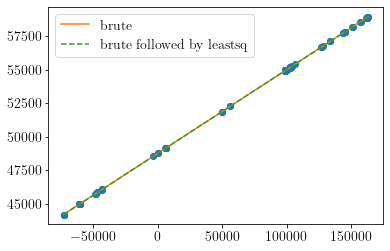

In [17]:
plt.plot(x, y, 'o')
plt.plot(x, y + linear_fit(result_brute.params, x, y), '-',
         label='brute')
plt.plot(x, y + linear_fit(best_result.params, x, y), '--',
         label='brute followed by leastsq')
plt.legend()
plt.show()

In [44]:
def plot_results_brute(result, best_vals=True, varlabels=None,
                       output=None):
    """Visualize the result of the brute force grid search.

    The output file will display the chi-square value per parameter and contour
    plots for all combination of two parameters.

    Inspired by the `corner` package (https://github.com/dfm/corner.py).

    Parameters
    ----------
    result : :class:`~lmfit.minimizer.MinimizerResult`
        Contains the results from the :meth:`brute` method.

    best_vals : bool, optional
        Whether to show the best values from the grid search (default is True).

    varlabels : list, optional
        If None (default), use `result.var_names` as axis labels, otherwise
        use the names specified in `varlabels`.

    output : str, optional
        Name of the output PDF file (default is 'None')
    """
    npars = len(result.var_names)
    _fig, axes = plt.subplots(npars, npars)

    if not varlabels:
        varlabels = result.var_names
    if best_vals and isinstance(best_vals, bool):
        best_vals = result.params

    for i, par1 in enumerate(result.var_names):
        for j, par2 in enumerate(result.var_names):

            # parameter vs chi2 in case of only one parameter
            if npars == 1:
                axes.plot(result.brute_grid, result.brute_Jout, 'o', ms=3)
                axes.set_ylabel(r'$\chi^{2}$')
                axes.set_xlabel(varlabels[i])
                if best_vals:
                    axes.axvline(best_vals[par1].value, ls='dashed', color='r')

            # parameter vs chi2 profile on top
            elif i == j and j < npars-1:
                if i == 0:
                    axes[0, 0].axis('off')
                ax = axes[i, j+1]
                red_axis = tuple(a for a in range(npars) if a != i)
                ax.plot(np.unique(result.brute_grid[i]),
                        np.minimum.reduce(result.brute_Jout, axis=red_axis),
                        'o', ms=3)
                ax.set_ylabel(r'$\chi^{2}$')
                ax.yaxis.set_label_position("right")
                ax.yaxis.set_ticks_position('right')
                ax.set_xticks([])
                if best_vals:
                    ax.axvline(best_vals[par1].value, ls='dashed', color='r')

            # parameter vs chi2 profile on the left
            elif j == 0 and i > 0:
                ax = axes[i, j]
                red_axis = tuple(a for a in range(npars) if a != i)
                ax.plot(np.minimum.reduce(result.brute_Jout, axis=red_axis),
                        np.unique(result.brute_grid[i]), 'o', ms=3)
                ax.invert_xaxis()
                ax.set_ylabel(varlabels[i])
                if i != npars-1:
                    ax.set_xticks([])
                else:
                    ax.set_xlabel(r'$\chi^{2}$')
                if best_vals:
                    ax.axhline(best_vals[par1].value, ls='dashed', color='r')

            # contour plots for all combinations of two parameters
            elif j > i:
                ax = axes[j, i+1]
                red_axis = tuple(a for a in range(npars) if a not in (i, j))
                X, Y = np.meshgrid(np.unique(result.brute_grid[i]),
                                   np.unique(result.brute_grid[j]))
                lvls1 = np.linspace(result.brute_Jout.min(),
                                    np.median(result.brute_Jout)/2.0, 7, dtype='int')
                lvls2 = np.linspace(np.median(result.brute_Jout)/2.0,
                                    np.median(result.brute_Jout), 3, dtype='int')
                lvls = np.unique(np.concatenate((lvls1, lvls2)))
                ax.contourf(X.T, Y.T, np.minimum.reduce(result.brute_Jout, axis=red_axis),
                            lvls, norm=LogNorm())
                ax.set_yticks([])
                if best_vals:
                    ax.axvline(best_vals[par1].value, ls='dashed', color='r')
                    ax.axhline(best_vals[par2].value, ls='dashed', color='r')
                    ax.plot(best_vals[par1].value, best_vals[par2].value, 'rs', ms=3)
                if j != npars-1:
                    ax.set_xticks([])
                else:
                    ax.set_xlabel(varlabels[i])
                if j - i >= 2:
                    axes[i, j].axis('off')

    if output is not None:
        plt.savefig(output)

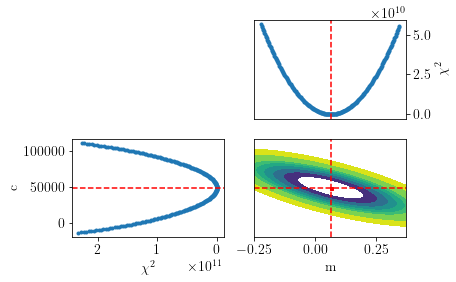

In [46]:
plot_results_brute(result_brute, best_vals=True, varlabels=None, output=None)

In [20]:
labels = ['x','y','f']
fig=plt.figure(figsize=(7,7),dpi=100)
fig=corner.corner(
    result_brute, labels=labels, quantiles=(0.16, 0.84),show_titles=True,
    title_fmt='g', use_math_text=True, fig=fig)
fig.show()

ValueError: It looks like the parameter(s) in column(s) 0 have no dynamic range. Please provide a `range` argument.

<Figure size 700x700 with 0 Axes>